General imports

In [ ]:
!pip install einops
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 386 (delta 3), reused 6 (delta 2), pack-reused 377 (from 1)
Receiving objects: 100% (386/386), 3.85 MiB | 7.70 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from sklearn.metrics import jaccard_score, f1_score, accuracy_score

Dataset

In [ ]:
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T

dataset = VOCSegmentation(root='data', year='2012', image_set='val', download=True, transform=T.ToTensor())

100%|██████████| 2.00G/2.00G [01:16<00:00, 26.3MB/s]


Extracting data/VOCtrainval_11-May-2012.tar to data


Method implementation - CAM

In [ ]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

In [ ]:
# class Baselines:
#     def __init__(self, model):
#         self.model = model
#         self.model.eval()

#     def generate_cam_attn(self, input, index=None):
#         output = self.model(input.cuda())
#         if index == None:
#             index = np.argmax(output.cpu().data.numpy())

#         one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
#         one_hot[0][index] = 1
#         one_hot = torch.from_numpy(one_hot).requires_grad_(True)
#         one_hot = torch.sum(one_hot.cuda() * output)

#         self.model.zero_grad()
#         one_hot.backward(retain_graph=True)
#         #################### attn
#         grad = self.model.blocks[-1].attn.get_attn_gradients()
#         cam = self.model.blocks[-1].attn.get_attention_map()
#         cam = cam[0, :, 0, 1:].reshape(-1, 14, 14)
#         grad = grad[0, :, 0, 1:].reshape(-1, 14, 14)
#         grad = grad.mean(dim=[1, 2], keepdim=True)
#         cam = (cam * grad).mean(0).clamp(min=0)
#         cam = (cam - cam.min()) / (cam.max() - cam.min())

#         return cam

In [ ]:
def visualize_CAM(input_image, class_index=None, use_thresholding=False):
    transformer_attribution = b.generate_cam_attn(input_image.unsqueeze(0).cuda(), index=class_index)
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
        transformer_attribution = transformer_attribution * 255
        transformer_attribution = transformer_attribution.astype(np.uint8)
        ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = input_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis, transformer_attribution

Load the model

In [ ]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)
# b = Baselines(model)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


In [ ]:
from baselines.ViT.ViT_new import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import Baselines

model1 = vit_LRP(pretrained=True).cuda()
model1.eval()
b = Baselines(model1)

Results

In [ ]:
def manipulate_img(image, true_mask):
    # Convert tensor image to numpy array and back to tensor after transformation
    image_np = image.permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)

    # Convert mask to numpy array and resize to match the image dimensions
    true_mask_np = np.array(true_mask)
    true_mask_np_resized = cv2.resize(true_mask_np, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Binarize the true mask (foreground is 1, background is 0)
    true_mask_np_resized = (true_mask_np_resized > 0).astype(np.uint8)

    # Convert images back to tensors
    image_tensor = transforms.ToTensor()(image_np)

    # Resize the original image to 224x224
    transform_resize = transforms.Compose([
        transforms.Resize((224, 224)),
    ])
    image_resized = transform_resize(image_tensor)

    return image_resized, true_mask_np_resized


Visualization

In [ ]:
for i in [16, 20, 37]:
  image, true_mask = dataset[i]
  image_resized, true_mask_np_resized = manipulate_img(image, true_mask)
# Convert tensor image to numpy array
  image_np_resized = image_resized.permute(1, 2, 0).numpy()
  image_np_resized = (image_np_resized * 255).astype(np.uint8)

  # Get model prediction and probability
  output = model(image_resized.unsqueeze(0).cuda())
  vis, vis_mask = visualize_CAM(image_resized, use_thresholding=True)
  plt.figure(figsize=(20, 5))
  plt.subplot(1, 4, 1)
  plt.title("Resized Original Image (224x224)")
  plt.imshow(image_np_resized)
  plt.axis('off')


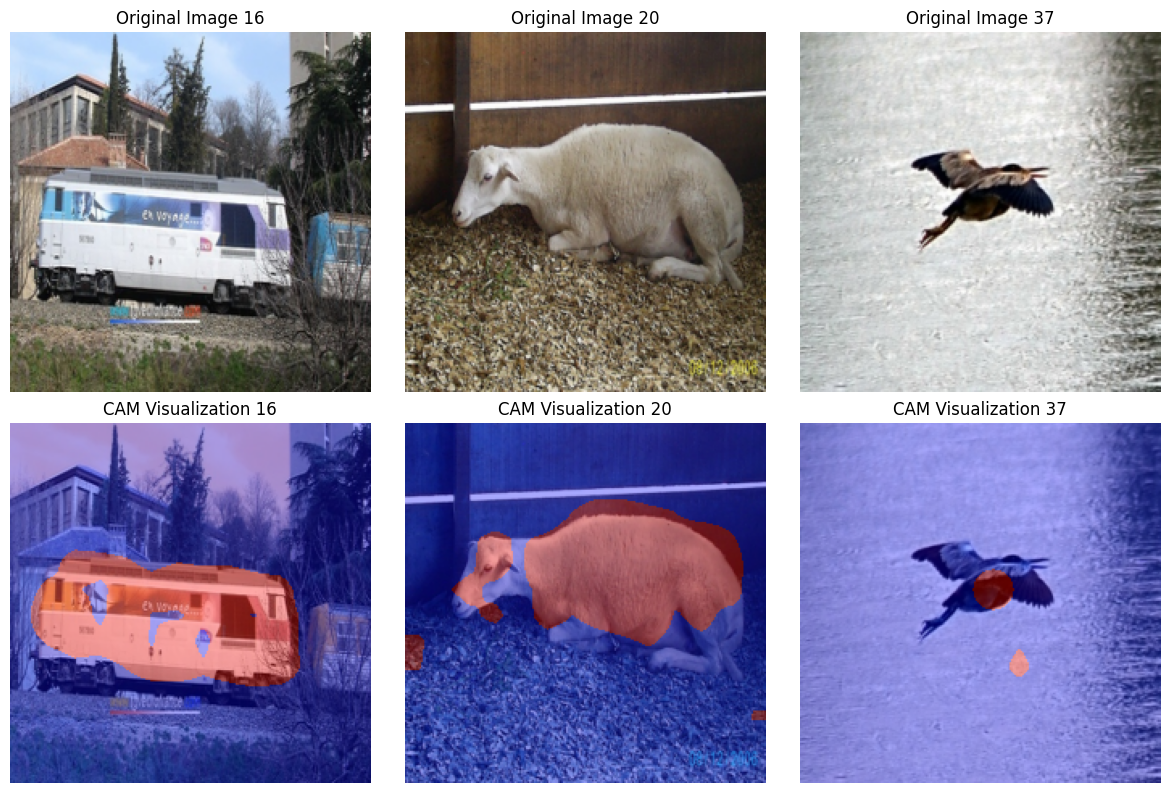

In [ ]:
import torchvision.transforms as transforms
# Create a plot with 2 rows and 3 columns for the images (original and CAM visualizations)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Loop through the selected dataset indices
for idx, i in enumerate([16, 20, 37]):
    # Load the image and its mask
    image, true_mask = dataset[i]
    image_resized, true_mask_np_resized = manipulate_img(image, true_mask)

    # Convert tensor image to numpy array
    image_np_resized = image_resized.permute(1, 2, 0).numpy()
    image_np_resized = (image_np_resized * 255).astype(np.uint8)

    # Get model prediction and probability
    output = model(image_resized.unsqueeze(0).cuda())

    # Generate CAM visualization
    vis, vis_mask = visualize_CAM(image_resized, use_thresholding=True)

    # Plot original image
    axes[0, idx].imshow(image_np_resized)
    axes[0, idx].set_title(f"Original Image {i}")
    axes[0, idx].axis('off')  # Hide axes

    # Plot the CAM visualization
    axes[1, idx].imshow(vis)
    axes[1, idx].set_title(f"CAM Visualization {i}")
    axes[1, idx].axis('off')  # Hide axes

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.savefig('cam_visualizations.png', dpi=300)
plt.show()

Metrics

In [ ]:
import torchvision.transforms as transforms

def print_top_classes(predictions):
    prob = torch.softmax(predictions, dim=1)
    top_prob, top_class = prob.topk(1, dim=1)
    return top_prob.item(), top_class.item()

# Define lists to store metrics
all_results = []

# Iterate over the validation dataset with tqdm
for idx in tqdm(range(len(dataset)), desc="Processing", unit="image"):
    image, true_mask = dataset[idx]

    image_resized, true_mask_np_resized = manipulate_img(image, true_mask)

    # Convert tensor image to numpy array
    image_np_resized = image_resized.permute(1, 2, 0).numpy()
    image_np_resized = (image_np_resized * 255).astype(np.uint8)

    # Get model prediction and probability
    output = model(image_resized.unsqueeze(0).cuda())
    top_prob, top_class = print_top_classes(output)

    # Only evaluate if the highest probability is greater than 70%
    if top_prob > 0.85:
          # Generate visualization
          vis, vis_mask = visualize_CAM(image_resized, use_thresholding=True)

          # Compute metrics
          predicted_mask_np = (vis_mask > 0.5).astype(np.uint8)
          true_mask_resized = cv2.resize(true_mask_np_resized, (224, 224), interpolation=cv2.INTER_NEAREST)

          # Flatten the masks for metric calculation
          true_mask_flat = true_mask_resized.flatten()
          predicted_mask_flat = predicted_mask_np.flatten()

          # Jaccard Index and F1 Score
          jaccard = jaccard_score(true_mask_flat, predicted_mask_flat)
          f1 = f1_score(true_mask_flat, predicted_mask_flat)

          # Pixel Accuracy
          pixel_accuracy = accuracy_score(true_mask_flat, predicted_mask_flat)

          # Store metrics
          all_results.append({
              "Image Index": idx,
              "Method": "CAM",
              "Jaccard Index (IoU)": jaccard,
              "F1 Score": f1,
              "Pixel Accuracy": pixel_accuracy
          })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Save results to CSV
results_df.to_csv("segmentation_metrics.csv", index=False)

print("Metrics have been saved to segmentation_metrics.csv")


Processing:   4%|▍         | 60/1449 [00:02<01:07, 20.65image/s]<ipython-input-16-7aa31e751940>:10: RuntimeWarning: invalid value encountered in cast
  transformer_attribution = transformer_attribution.astype(np.uint8)
Processing:  40%|████      | 586/1449 [00:26<00:32, 26.96image/s]<ipython-input-16-7aa31e751940>:10: RuntimeWarning: invalid value encountered in cast
  transformer_attribution = transformer_attribution.astype(np.uint8)
Processing:  86%|████████▌ | 1239/1449 [00:55<00:08, 25.82image/s]<ipython-input-16-7aa31e751940>:10: RuntimeWarning: invalid value encountered in cast
  transformer_attribution = transformer_attribution.astype(np.uint8)
Processing:  92%|█████████▏| 1327/1449 [00:59<00:06, 18.22image/s]<ipython-input-16-7aa31e751940>:10: RuntimeWarning: invalid value encountered in cast
  transformer_attribution = transformer_attribution.astype(np.uint8)
Processing: 100%|██████████| 1449/1449 [01:04<00:00, 22.33image/s]

Metrics have been saved to segmentation_metrics.csv


In [ ]:
# Load the CSV file
results_df = pd.read_csv("segmentation_metrics.csv")

# Calculate the average metrics per method
average_metrics = results_df.groupby('Method').mean().reset_index()

# Save the average metrics to a new CSV file
average_metrics.to_csv("average_segmentation_metrics_85.csv", index=False)

# Print the average metrics
print(average_metrics)

  Method  Image Index  Jaccard Index (IoU)  F1 Score  Pixel Accuracy
0    CAM   722.642651             0.124291  0.191258        0.659441
